In [1]:
pwd

'/mnt/md0/isshamie/Projects/Mito_Trace/workflow/notebooks/clone_af_dendrograms'

In [2]:

# INDIR = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/"
# OUTDIR = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/barcodes/btwnClones_dendro_dt_0.6/"
# DONOR = 0
# dendroThresh=0.6

#clones_meta = '/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/results/clones_summary/feb23_2022/clones_summary.csv'
#clones_indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/"
#clone_sizes_in_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/gff_A2_black/annotation_clones/clone_counts/minCellConds_1/clone_sizes.csv"


INDIR = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_mgatkdonor/knn/kparam_30"
OUTDIR = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_mgatkdonor/knn/kparam_30/barcodes/btwnClones_dendro_dt_0.6"
DONOR = 1 
dendroThresh = 0.6

verbose=False

In [3]:
import src.utils.dendro_clust as dc

import mplh.cluster_help as ch
import mplh.fig_utils as fu

from os.path import join, exists, dirname
from glob import glob
import pickle
import os
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
from scipy.stats import hypergeom
print(vireoSNP.__version__)
import pandas as pd
import seaborn as sns
from vireoSNP import Vireo
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})
import scipy
from itertools import combinations
#from src.utils import utils  as ut

fig_utils from mplh
0.5.6


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
out_f = join(OUTDIR, f"donor{DONOR}")


### Load cells_meta 
### Create clones_meta - get number of cells in a clone and donor

In [6]:
cells_meta = pd.read_csv(join(INDIR, "cells_meta.tsv"), sep="\t")
cells_meta["lineage"] = cells_meta.apply(lambda x: f'{x["donor"]}_{x["lineage"]}', axis=1)
cells_meta

,ID,lineage,donor,condition
0,AAACGAAAGAATCAAC-1_Control,0_0,0,Control
1,AAACGAAGTTTGACCA-1_Input,0_0,0,Input
2,AAACTGCAGACTTCCA-1_Input,0_0,0,Input
3,AAACTGCCATGTGGGA-1_Flt3l,0_0,0,Flt3l
4,AAACTGCGTAACTGAA-1_Control,0_0,0,Control
...,...,...,...,...
17293,CCACGTTTCTCGACAA-1_Flt3l,1_53,1,Flt3l
17294,CCATACCGTCGCGCTA-1_Flt3l,1_53,1,Flt3l
17295,CTAACTTAGACTTGAA-1_Flt3l,1_53,1,Flt3l
17296,CTGAATGAGAACGTCG-1_Flt3l,1_53,1,Flt3l


In [7]:
clones_meta_df = pd.DataFrame(cells_meta.groupby("lineage").size(), columns=["size"]) #, index=["size"])
clones_meta_df["donor"] = [x.split("_")[0] for x in clones_meta_df.index]
clones_meta_df["donor"] = clones_meta_df["donor"].astype(int)
clones_meta_df

,size,donor
lineage,,
0_0,782,0
0_1,557,0
0_10,202,0
0_11,200,0
0_12,198,0
...,...,...
1_53,5,1
1_6,244,1
1_7,235,1


In [8]:
curr_clones = clones_meta_df[clones_meta_df["donor"]==DONOR]
# cells_meta = pd.read_csv(join(INDIR, "cells_meta.tsv"), sep='\t')#.sort_values(["donor", "lineage"])
curr_labels = cells_meta[cells_meta["donor"]==DONOR]

In [9]:
# curr_clones = clones_meta_df[clones_meta_df["donor"]==DONOR].set_index("lineage")
# curr_clones

## Load AF and DP

In [10]:
af_indir = join(INDIR, "sc_af", f"donor{DONOR}")
AF_df = pd.read_csv(join(af_indir, "af.tsv"), index_col=0, sep="\t")
DP_df = pd.read_csv(join(af_indir, "dp.tsv"), index_col=0, sep="\t")


### Functions to get mean and median

In [11]:
def calc_mean(cells, af):
    #print(cells.head())
    return af.loc[:,cells["ID"].values].mean(axis=1)

def calc_median(cells, af):
    #print(cells.head())
    return af.loc[:,cells["ID"].values].median(axis=1)

### Calculate clone-barcode mean

In [12]:
mean_af = curr_labels.groupby(["lineage"]).apply(calc_mean, af=AF_df)
anno = mean_af.reset_index()[["lineage"]]

# Remove clones that have all 0
# print('mean_af shape', mean_af.shape)
# mean_af = mean_af.loc[~((mean_af==0).all(axis=1))]
# curr_clones = curr_clones.loc[mean_af.index]
# print('mean_af shape after rm 0', mean_af.shape)

mean_dp = curr_labels.groupby(["lineage"]).apply(calc_mean, af=np.log2(DP_df+1))
mean_dp = mean_dp.loc[mean_af.index, mean_af.columns]

#mean_dp = mean_dp.reset_index(drop=True)
anno_dp = mean_dp.reset_index()[["lineage"]]
na_cells = curr_labels.loc[curr_labels["lineage"].isnull()]
na_mean_af = na_cells.groupby("condition").apply(calc_mean, af=AF_df)

if not (na_mean_af.shape[0] == 0):
    print('na shape', na_mean_af.shape)
    na_anno = pd.concat((anno,pd.DataFrame({"lineage":["None"]*len(na_mean_af.index)})), ignore_index=True)
    na_concat = pd.concat((mean_af.reset_index(drop=True), na_mean_af.reset_index(drop=True)), ignore_index=True)
    na_mean_dp = na_cells.groupby("condition").apply(calc_mean, af=np.log2(DP_df+1))
    na_dp_concat = pd.concat((mean_dp, na_mean_dp.reset_index(drop=True)), ignore_index=True)
else:
    na_anno = anno
    na_concat = mean_af.reset_index(drop=True)
    na_dp_concat = mean_dp
     
mean_af  

Variant,1949G>A,3244G>A,7598G>A,8292G>A,10589G>A,11453G>A,15497G>A,16129G>A,16355C>A,58T>C,...,7028C>G,10397A>G,15452C>G,64C>T,8461C>T,11761C>T,13188C>T,15326A>T,16296C>T,16355C>T
lineage,,,,,,,,,,,,,,,,,,,,,
1_0,0.002181,0.003213,0.006548,0.008366,0.007650,0.000285,0.000049,0.003936,0.000206,0.008506,...,0.000413,0.008733,0.001990,0.006768,0.006751,0.009847,0.008163,0.000103,0.020836,0.009874
1_1,0.000776,0.003969,0.001283,0.001090,0.002134,0.000141,0.001490,0.000238,0.000621,0.000978,...,0.000200,0.001667,0.000407,0.001139,0.002018,0.001361,0.002524,0.000029,0.984860,0.000699
1_10,0.000445,0.000481,0.004116,0.002823,0.003239,0.000062,0.000000,0.000170,0.000157,0.001249,...,0.000043,0.001581,0.000137,0.001145,0.003860,0.004947,0.002241,0.000000,0.991137,0.000878
1_11,0.001265,0.013995,0.002956,0.004323,0.001359,0.000322,0.000000,0.000858,0.000394,0.001686,...,0.000000,0.003257,0.000000,0.000673,0.002359,0.005497,0.081616,0.000028,0.988722,0.000671
1_12,0.002832,0.006057,0.004322,0.003186,0.003130,0.000577,0.000000,0.011636,0.000000,0.002146,...,0.000052,0.002353,0.000000,0.001493,0.004816,0.089927,0.004069,0.000338,0.990885,0.001103
1_13,0.000815,0.005947,0.005377,0.012049,0.015575,0.001295,0.000769,0.002257,0.000000,0.002662,...,0.000185,0.006545,0.000406,0.003268,0.011220,0.007399,0.012431,0.000700,0.952092,0.111799
1_14,0.000147,0.000933,0.000434,0.000063,0.000000,0.000206,0.000000,0.005383,0.000762,0.000520,...,0.000265,0.000083,0.000401,0.000486,0.000088,0.000039,0.000000,0.000179,0.997562,0.000000
1_15,0.001135,0.002317,0.008313,0.006501,0.004094,0.000607,0.000868,0.010803,0.000417,0.001285,...,0.002208,0.116744,0.000000,0.001771,0.003209,0.004088,0.009557,0.000186,0.984310,0.001235
1_16,0.002465,0.004206,0.003262,0.005184,0.002979,0.000090,0.064206,0.009438,0.002221,0.000827,...,0.000319,0.001293,0.000164,0.000860,0.002537,0.003797,0.004573,0.000000,0.993179,0.000819


In [13]:
# mean_af.to_csv(out_f+".initInds.mean.csv")

# curr_clones[["donor","size", "log2_fold","-log10(fold p_adj)", "shuffle_sig", 
#              "ncells"]+ list(curr_labels["condition"].unique())].to_csv(out_f+".initInds.indsMeta.csv")

### Cluster to get dendro results

In [14]:
g = sns.clustermap(mean_af, row_cluster=True, col_cluster=True, vmax=0.2, vmin=0)
inds = g.dendrogram_row.dendrogram["leaves"]
cols = g.dendrogram_col.dendrogram["leaves"]
curr_clones = curr_clones.iloc[inds]
plt.close(g.fig)

### Cluster and calculate proper size

('C0', 'C1')
('C0', 'C2')
('C1', 'C2')


,size,donor,den_clust
lineage,,,
1_0,540,1,C0
1_1,328,1,C2
1_10,219,1,C1
1_11,207,1,C1
1_12,204,1,C1
1_13,197,1,C1
1_14,192,1,C1
1_15,192,1,C1
1_16,182,1,C2


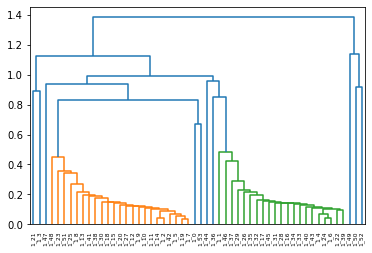

In [15]:
%matplotlib inline
den = dc.dendro_cluster(mean_af, g, d_thresh=dendroThresh)


if verbose:
    print('icoord and color list')
    print(len(den["icoord"]))
    print(len(den["color_list"]))
    print('leaves leaves color and mean_af shape')
    print(len(den["leaves"]))
    print(len(den["leaves_color_list"]))
    print(mean_af.shape)



# cluster_classes = dc.get_cluster_classes(den)
curr_clones = dc.add_cluster_labels(den,curr_clones)
curr_clones

size_pvals = dc.cluster_stats(curr_clones, out_f= out_f )

curr_clones["donor"]= [x.split("_")[0] for x in curr_clones.index]
curr_clones = curr_clones.loc[mean_af.index]

# with open(out_f + ".dendrogram_pvals.txt", "w") as f:
#     #for l in size_pvals:
#     f.write("\n".join(size_pvals))

curr_clones


## Group clones using dendrogram and run stats on size differences in the groups

### Run ranksums on clone size btwn debdrogram clusters

In [16]:
# size_pvals = []
# for pair in combinations(curr_clones["den_clust"].unique(),2):
#     print(pair)
#     stat, p_val = scipy.stats.ranksums(curr_clones.loc[curr_clones["den_clust"]==pair[0], "size"].values, 
#                          y=curr_clones.loc[curr_clones["den_clust"]==pair[1], "size"].values, 
#                          alternative='two-sided')

#     size_pvals.append(f"{pair[0]}, {pair[1]}, {str(p_val)}")
    


## Plot with dendro clusters

In [17]:
conditions = cells_meta["condition"].unique()

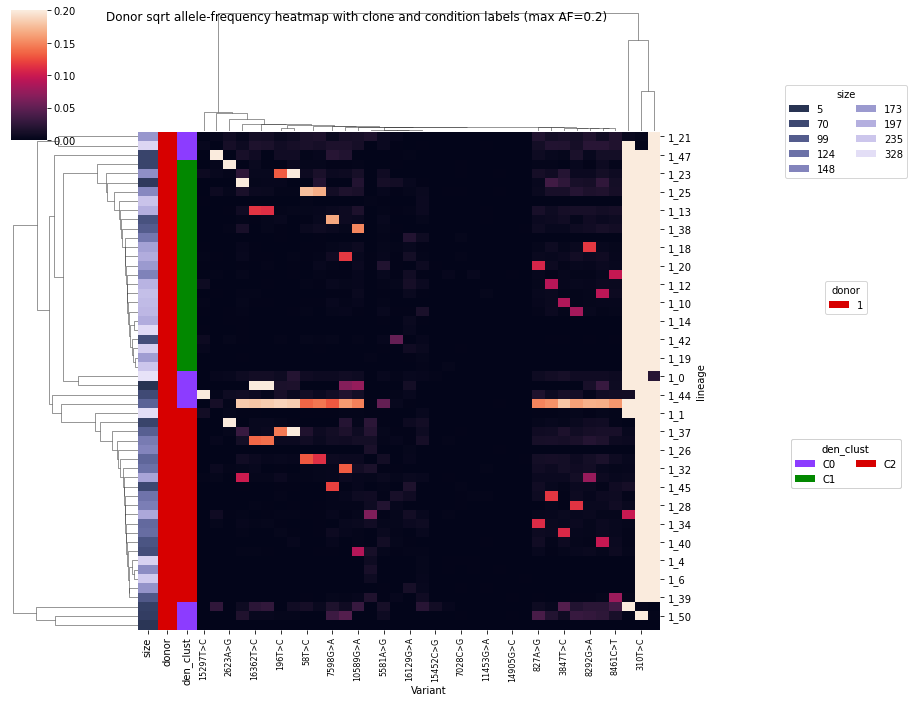

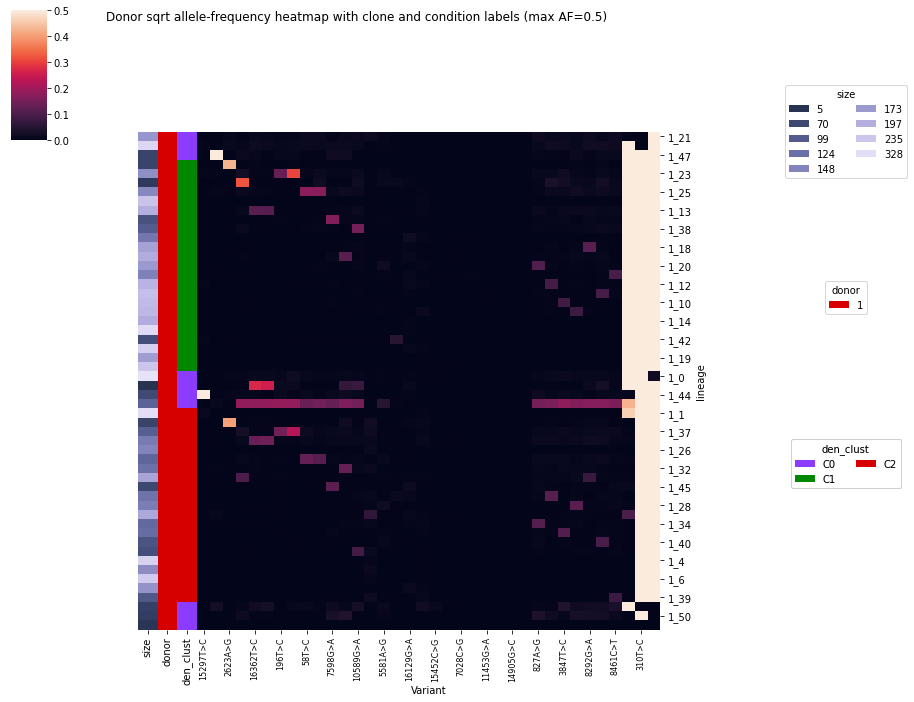

In [18]:
g = ch.plot_cluster(mean_af,row_meta=curr_clones, to_row_clust=True, to_col_clust=True,
                row_clr_schemes={"size":"sequential","donor":"categorical","den_clust":"categorical"}, 
                vmax=0.2, vmin=0)
plt.suptitle("Donor sqrt allele-frequency heatmap with clone and condition labels (max AF=0.2)")
#fu.helper_save(out_f+"withEnrichmentFoldChange.NoCondition.clust.max2.AF.png",to_pdf=False)
fu.helper_save(out_f+".dendro.NoCondition.max2.AF.png",to_pdf=False)

inds = g.dendrogram_row.dendrogram["leaves"]
cols = g.dendrogram_col.dendrogram["leaves"]

mean_af = mean_af.iloc[inds,cols]
curr_clones = curr_clones.loc[mean_af.index]

ch.plot_cluster(mean_af,row_meta=curr_clones, to_row_clust=False, to_col_clust=False,
                row_clr_schemes={"size":"sequential","donor":"categorical","den_clust":"categorical"}, 
                vmax=0.5, vmin=0)
plt.suptitle("Donor sqrt allele-frequency heatmap with clone and condition labels (max AF=0.5)")
#fu.helper_save(out_f+"withEnrichmentFoldChange.NoCondition.clust.max5.AF.png",to_pdf=False)
fu.helper_save(out_f+".dendro.NoCondition.max5.AF.png",to_pdf=False)



### Save mean_af and curr_clonnes

In [19]:
mean_af.to_csv(out_f+".mean.csv")
curr_clones.to_csv(out_f+".clones_dendro.csv")